In [833]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [834]:
#Loading the cleaned data from the EDI step
data = pd.read_csv("../Data/cleaned_data.csv", index_col = 0)

In [835]:
print(f"Features selected for the models: \n\n{data.columns}")

Features selected for the models: 

Index(['Year', 'Month', 'Latitude', 'Longitude', 'Depth', 'Region',
       'Coral_cover', 'Reef_complexity', 'SST', 'NPP', 'Wave_exposure',
       'Habitat_type_classLV2', 'Coral_area_UFRTM_20km',
       'Coral_area_UFRTM_200km', 'Depth_Sbrocco', 'Deepwater', 'FSA',
       'Marina_slips_10km', 'Marina_slips_25km', 'Marine_reserve',
       'Population_20km', 'Population_50km', 'Recreational_fishermen_50km',
       'Tourist_fishing', 'SG_permits_50km', 'SG_charter_permits_25km',
       'Total_gravity', 'Keys_Divisions', 'Nursery_mangroves',
       'Commercial_pounds_landed', 'Pop_per_area_reef_20km', 'impact',
       'HABITAT_CD', 'Diversity_index'],
      dtype='object')


### Discretization

In order to discretize Diversity_index, we start by analysing its distribuition:

In [839]:
data.Diversity_index.describe()

count    3292.000000
mean        0.832254
std         0.116764
min         0.000000
25%         0.814384
50%         0.869306
75%         0.900666
max         0.953566
Name: Diversity_index, dtype: float64

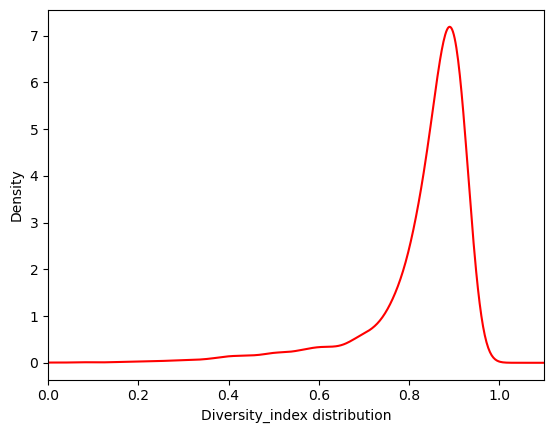

In [840]:
#Plotting the distribution
data.Diversity_index.plot.kde(color = 'red')
plt.xlabel("Diversity_index distribution")
plt.xlim(0, 1.1)

plt.show()

* As shown in the plot, the distribution seems to have a long left tail, with most of the data concentrated on the right, where we have the peak. 

* The mean is closer to the higher values on the right.

In [842]:
#Checking how many values are bellow the mean.
threshold = data.Diversity_index.describe()["mean"]

#Identify possible outlier
possible_outliers = data[data["Diversity_index"] < threshold]
total_outliers = len(possible_outliers.index)

print(f"Ammount of Diversity_index values smaller than {threshold:.2f} (mean):\n\n{(total_outliers/data.Diversity_index.count())*100:.2f}% of the dataset ({total_outliers} values)")

Ammount of Diversity_index values smaller than 0.83 (mean):

31.17% of the dataset (1026 values)


These values can be better visualized in the histogram bellow.

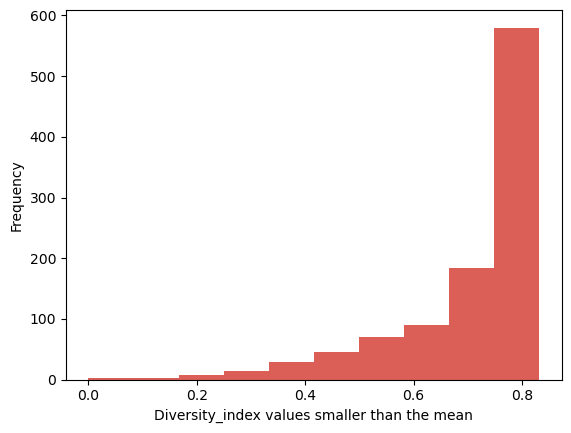

In [844]:
#Filter all the Diversity_index smaller than the mean
less_than_mean = data[data["Diversity_index"] < threshold]

#Plot the histogram
less_than_mean.Diversity_index.plot.hist(color = sns.color_palette('hls', 1))
plt.xlabel("Diversity_index values smaller than the mean")

plt.show()

* There remains a significant frquency jump, around 0.70 - 0.80. 

* To better understand this variation, we will try to isolate the outliers.

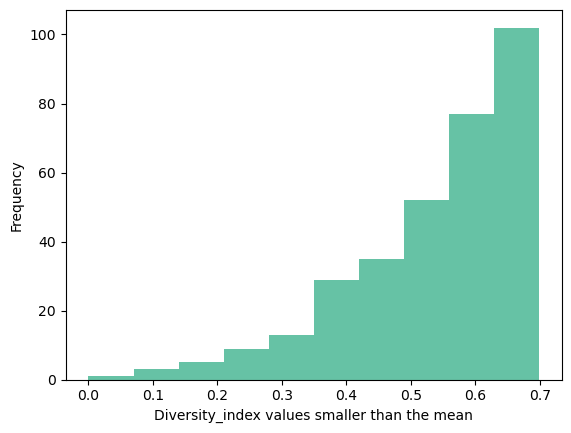

In [846]:
#Filter all the Diversity_index smaller than the 0.70
outliers = data[data["Diversity_index"] < 0.70]

#Plot the histogram
outliers.Diversity_index.plot.hist(color = sns.color_palette('Set2', 2))
plt.xlabel("Diversity_index values smaller than the mean")

plt.show()

- By looking at the quantiles, the distribuition and the histograms above, we confirm the imbalance in the Diversity_index's value range when comparing with the mean, which will influence how we categorize the data into the proposed classes.

* About 70% of the values are bigger or equal than the mean. 

* However, we have a small range of outliers that span from 0.0 until 0.7 (roughly 30%)

- With that in mind, we decide to divide the Diversity_index into 3 categories (Low, Medium, High)
    * **Low:** 
        * All the lower-bounded outliers (< 0.7) were put into this category. 
        * While this is smaller group, it will make the characteziation of the problem more accurate:
            * For example, evenly dividing values through quantile binning would result in a "Low" class with a range from 0.0 to 0.8, which wouldn’t very accurately represent the reality.
            
    * **Medium:**
        * Anything from the highest outlier up to the mean.
        * This category took into consideration the values that would best represent a "medium range", given the real-world problem we are trying to solve, and also the imbalance in the data.
    * **High:** 
        * Finally, this last category contains all the values higher than the mean.

In summary:

* **Low:**    
[0 - 0.7)
* **Medium:**    
[0.7 - mean)
* **High:**    
[mean - 1]

#### Dividing into bins

In [850]:
#Name of the feature which will represent the target class
target_name = "Diversity Index Level"

mean = data.Diversity_index.describe()["mean"]

#The categories Low, Medium and High
labels = ['Low', 'Medium', 'High']

#Define the interval of each class
bins = [0, 0.7, mean, 1]

#Split the Diversity_index into the classes
data[target_name] = pd.cut(data["Diversity_index"], bins=bins, labels=labels)

#To force the Diversity_index with value 0.0 into the Low class as it was not done by pd.cut()
data[target_name] = data[target_name].fillna("Low")


#Generate the summary of the class division
print("\n == Class Intervals:\n")

for i in labels:
    class_stats = data.loc[data[target_name] == i, "Diversity_index"].describe()
    print(f"{i:<{10}} Min: {class_stats['min']:<{10}.4f} Max: {class_stats['max']:.4f}")
    
    
print("\n\n== Frequency:\n")
print(data[target_name].value_counts())


 == Class Intervals:

Low        Min: 0.0000     Max: 0.6991
Medium     Min: 0.7000     Max: 0.8322
High       Min: 0.8323     Max: 0.9536


== Frequency:

Diversity Index Level
High      2266
Medium     700
Low        326
Name: count, dtype: int64


## Class Division Analysis and Data Splitting

In [852]:
#Data splitting
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

### Data Splitting

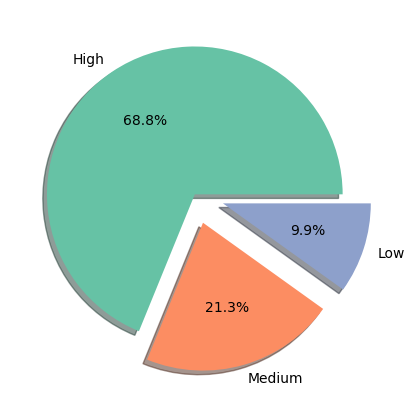

In [854]:
#PLotting the classes distribuition
category_name = data[target_name].unique()
plt.pie(data[target_name].value_counts(), 
        labels = category_name,  
        shadow=True, 
        explode = [0,0.2,0.2],
        autopct='%1.1f%%',
       colors=sns.color_palette('Set2'))

plt.show()

* As expected, we have a class imbalance given our decision to classify the outliers in one class.

* To address this problem, we have used oversampling technique.

#### Oversampling

In [857]:
#Removing target feature
X = data.drop(columns=[target_name])
y = data[target_name]

# Handle class imbalance using SMOTE with adjusted k_neighbors parameter
smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify = y_resampled)

Class distribution after oversampling:

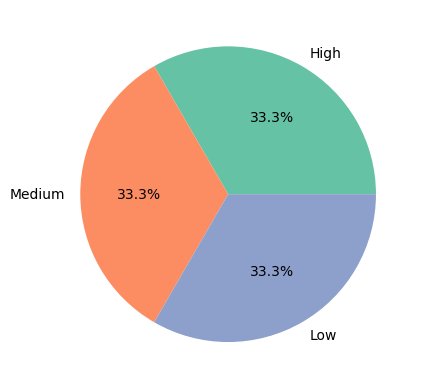

== Frequency:

Diversity Index Level
Low       2266
Medium    2266
High      2266
Name: count, dtype: int64


In [859]:
#Plotting a pie chart with the classes distribuition

category_name = y_resampled.unique()
plt.pie(y_resampled.value_counts(), 
        labels = category_name,  
        autopct='%1.1f%%',
       colors=sns.color_palette('Set2'))
plt.show()

print("== Frequency:\n")
print(y_resampled.value_counts())

* Now that the class imbalance issue has been addressed, we check if the split of the dataset did not create any new disparity.

In [861]:
print("Diversity_index (mean): \n")
print(f"Full Data Set: {X_resampled.Diversity_index.mean()}")
print(f"Test Data Set: {X_test.Diversity_index.mean()}")
print(f"Train Data Set: {X_train.Diversity_index.mean()}")

Diversity_index (mean): 

Full Data Set: 0.7373297678703363
Test Data Set: 0.7375825248629408
Train Data Set: 0.7372454824863763


##### Dropping Diversity_index

Diversity_index not needed anymore as it has now been discretized.

In [864]:
X_test = X_test.drop("Diversity_index", axis = 1)
X_train = X_train.drop("Diversity_index", axis = 1)

# Model

* For this part, our initial approach is first start with a linear model, as it tends to have a lower computational cost.

* After that, we compare different non-linear models.

* Finally, we compare the results of the different models.

In [867]:
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Reports
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [868]:
# Support code that generates the classification report and saves the f1-score information for comparison later:

f1_scores = {}
#Generate classification report
def generate_classification_report(model_name, y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    #Save F1 scores information for comparison
    f1_scores.update({model_name:{'High': report['High']['f1-score'],
      'Medium':  report['Medium']['f1-score'],
        'Low': report['Low']['f1-score']}})

## Linear Model

### Logistic Regression

In [871]:
#Model initialization
logistic_regression_model = LogisticRegression(random_state= 45 ,max_iter=1000)

#Model training
logistic_regression_model.fit(X_train, y_train)

#Model testing
y_pred = logistic_regression_model.predict(X_test)

C:\Users\cetle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Confusion Matrix (Logistic Regression):**

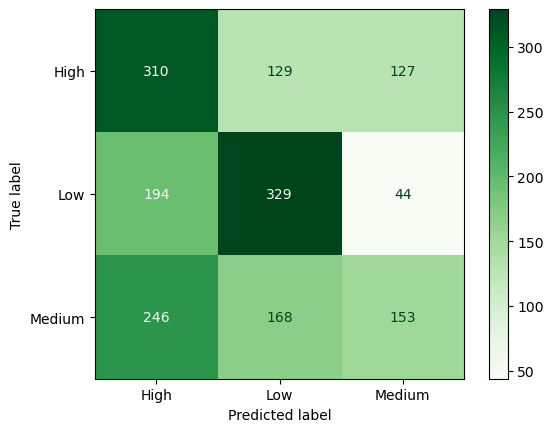

In [873]:
#Generate confusion matrix
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Greens")

**Classification Report (Logistic Regression):**

In [875]:
#report = classification_report(y_test, y_pred, output_dict=True)
generate_classification_report("Logistic Regression", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.41      0.55      0.47       566
         Low       0.53      0.58      0.55       567
      Medium       0.47      0.27      0.34       567

    accuracy                           0.47      1700
   macro avg       0.47      0.47      0.46      1700
weighted avg       0.47      0.47      0.46      1700



**Conclusion:**

* The Logistic Regression model doesn't seem to fit the problem correctly which might indicate that a non-linear model might be more adequate.

* In addition, the model did not converge within the maximum number of iterations.

* It's also possible that we are dealing with a non-linear dataset.

## Non-Linear Models

### Random Forest

In [880]:
#Model initialization
random_forest_model = RandomForestClassifier(random_state= 42)

#Model training
random_forest_model.fit(X_train, y_train)

#Model testing
y_pred = random_forest_model.predict(X_test)

**Confusion Matrix (Random Forest):**

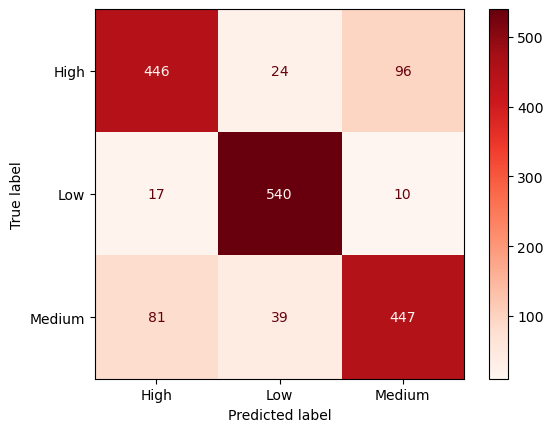

In [882]:
#Generate confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Reds")

**Classification Report (Random Forest):**

In [884]:
#report = classification_report(y_test, y_pred)
generate_classification_report("Random Forest", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.82      0.79      0.80       566
         Low       0.90      0.95      0.92       567
      Medium       0.81      0.79      0.80       567

    accuracy                           0.84      1700
   macro avg       0.84      0.84      0.84      1700
weighted avg       0.84      0.84      0.84      1700



**Conclusion (Random Forest):**

[TO-DO]

### Decision Tree

In [888]:
#Model initialization
decision_tree_model = DecisionTreeClassifier(random_state= 42)

#Model training
decision_tree_model.fit(X_train, y_train)

#Model testing
y_pred = decision_tree_model.predict(X_test)

**Confusion Matrix (Decision Tree):**

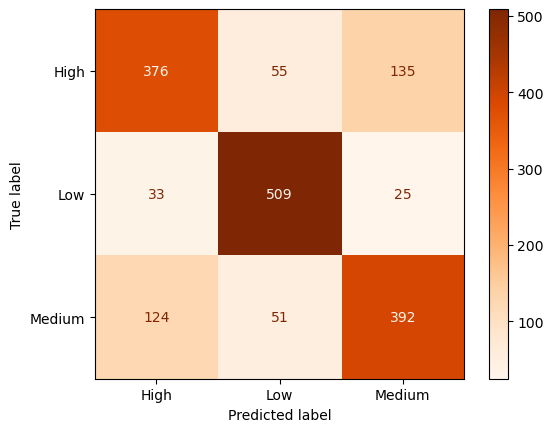

In [890]:
#Generate confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Oranges")

**Classification Report (Decision Tree):**

In [892]:
generate_classification_report("Decision Tree", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.71      0.66      0.68       566
         Low       0.83      0.90      0.86       567
      Medium       0.71      0.69      0.70       567

    accuracy                           0.75      1700
   macro avg       0.75      0.75      0.75      1700
weighted avg       0.75      0.75      0.75      1700



**Conclusion (Decision Tree):**

[TO-DO]

#### Multi-Layer Perceptron classifier

Finally, we compare it with a neural network model.

In [897]:
#Model initialization
mlpc_model = MLPClassifier(hidden_layer_sizes=(15,20, 5),max_iter=1000, random_state = 42,  activation='tanh')

#Model training
mlpc_model.fit(X_train, y_train)

#Model testing
y_pred = mlpc_model.predict(X_test)

**Confusion Matrix (MLPC):**

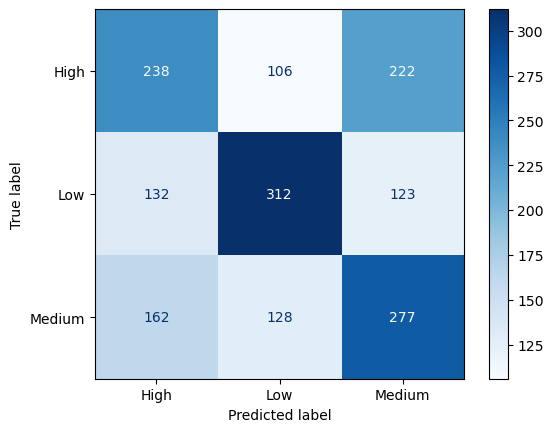

In [899]:
#Generate confusion matrix
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = "Blues")

**Classification Report (MLPC):**

In [901]:
generate_classification_report("MLPC", y_test, y_pred)

              precision    recall  f1-score   support

        High       0.45      0.42      0.43       566
         Low       0.57      0.55      0.56       567
      Medium       0.45      0.49      0.47       567

    accuracy                           0.49      1700
   macro avg       0.49      0.49      0.49      1700
weighted avg       0.49      0.49      0.49      1700



**Conclusion (MLPC):**

[TO-DO]

### Comparison

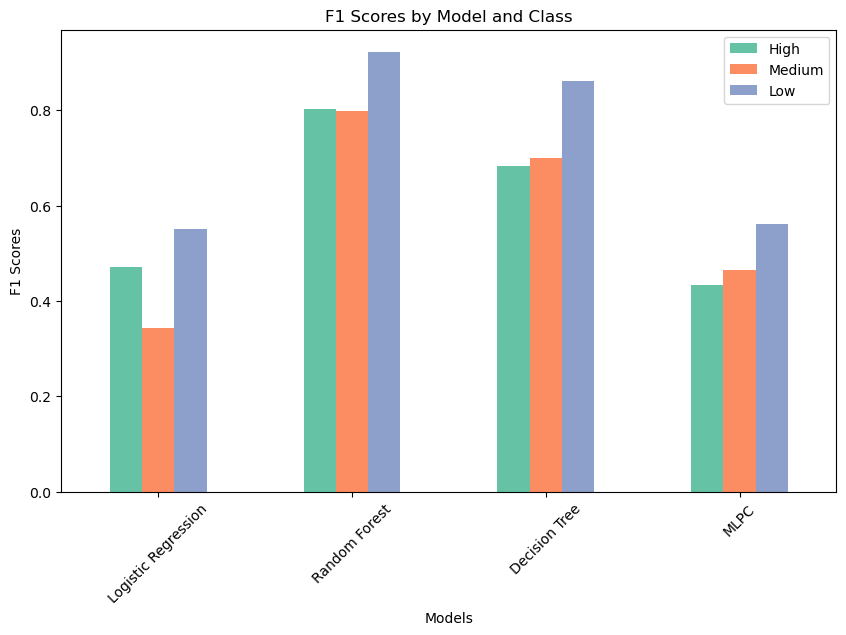

In [905]:
#Transforming the dictionary into Data Frame
df_f1_scores = pd.DataFrame(f1_scores).T

f1_hist = df_f1_scores.plot(kind='bar', color = sns.color_palette('Set2', 3), figsize=(10, 6))

f1_hist.set_xlabel('Models')
f1_hist.set_ylabel('F1 Scores')
f1_hist.set_title('F1 Scores by Model and Class')


plt.xticks(rotation=45)
plt.show()

[TO-DO]